<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score,
    recall_score, 
    roc_curve, 
    roc_auc_score 
)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from tqdm import tqdm

## Подготовка данных

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Приведем названия к змеиному регистру и сделаем их более компактными.

In [3]:
data = data.rename(columns={'RowNumber':'row', 'CustomerId':'id', 'Surname':'surname', 'CreditScore':'credit_score', 'Geography':'geography',
                   'Gender':'gender', 'Age':'age','Tenure':'tenure','Balance':'balance','NumOfProducts':'num_of_products',
                   'HasCrCard':'credit_card', 'IsActiveMember':'is_active_member', 'EstimatedSalary':'salary', 'Exited':'churn'})
data.head()

,row,id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,credit_card,is_active_member,salary,churn
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим пропуски.

In [4]:
data.isna().sum()

row                   0
id                    0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
credit_card           0
is_active_member      0
salary                0
churn                 0
dtype: int64

Пропуски в столбце "tenure" - клиентский стаж. Столбец скорее всего важен для прогнозирования, поэтому заполнять его любыми значениями кажется нецелесообразным, а самих пропусков менее 10%, поэтому пренебрежем этими данными.

Так же для исследования нам вряд ли понадобятся фамилии клиентов, id и номер строки, удалим и их.

In [5]:
data = data.drop(['surname', 'id', 'row'], axis=1)
data = data.dropna(subset=['tenure'])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   credit_card       9091 non-null   int64  
 8   is_active_member  9091 non-null   int64  
 9   salary            9091 non-null   float64
 10  churn             9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


,credit_score,geography,gender,age,tenure,balance,num_of_products,credit_card,is_active_member,salary,churn
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим дубликаты.

In [6]:
data.duplicated().sum()

0

Дубликатов нет, идём дальше.

Нам необходимо преобразовать данные категориальные в данные числовые. У нас к категориальным данным относятся пол и география клиента. 

In [7]:
encoder = OrdinalEncoder()
encoder.fit(data)
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)
data_ordinal.info()
data_ordinal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   float64
 1   geography         9091 non-null   float64
 2   gender            9091 non-null   float64
 3   age               9091 non-null   float64
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   float64
 7   credit_card       9091 non-null   float64
 8   is_active_member  9091 non-null   float64
 9   salary            9091 non-null   float64
 10  churn             9091 non-null   float64
dtypes: float64(11)
memory usage: 781.4 KB


,credit_score,geography,gender,age,tenure,balance,num_of_products,credit_card,is_active_member,salary,churn
0,226.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4609.0,1.0
1,215.0,2.0,0.0,23.0,1.0,679.0,0.0,0.0,1.0,5119.0,0.0
2,109.0,0.0,0.0,24.0,8.0,5277.0,2.0,1.0,0.0,5182.0,1.0
3,306.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4274.0,0.0
4,457.0,2.0,0.0,25.0,2.0,3374.0,0.0,1.0,1.0,3559.0,0.0


Рассмотрим распределение значений целевого признака "churn".

In [8]:
data_ordinal['churn'].value_counts()

0.0    7237
1.0    1854
Name: churn, dtype: int64

Очевиден дисбаланс признаков. Необходимо корректирование распределения.

**Итак:**

1) Выполнено приведение названий столбцов к змеиному регистру;

2) Обработаны пропуски;

3) Подтверждено отсутствие явных дубликатов;

4) Произведен перевод категориальных прзнаков в числовые;

5) Обнаружен дисбаланс целевого признака, который необходимо будет учесть на этапе обучения модели.

## Исследование задачи

Создаем переменные для хранения признаков и целевого признака.

In [9]:
target = data_ordinal['churn']
features = data_ordinal.drop(['churn'],axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, 
                                                                               random_state=1)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, 
                                                                            test_size = 0.25, random_state=1)
print(features_train.shape, features_valid.shape, features_test.shape)

(5454, 10) (1819, 10) (1818, 10)


Всё отлично: подготовлены тренировочная, валидационная и тестовая выборки.

Попробуем поучиться без балансировки.

In [10]:
from tqdm import tqdm # добавлено
best_f1 = 0
for depth in tqdm(range(1,11,1)):
    for estimators in range(1,91,1):
        model = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=estimators)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        if f1_score(target_valid, predicted_valid) > best_f1:
            best_f1 = f1_score(target_valid, predicted_valid)
            best_depth = depth
            best_estimators = estimators
            
            print("F1:", round(f1_score(target_valid, predicted_valid), 4), "depth:", best_depth, 
                  "estimators:", best_estimators)        

  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.044 depth: 1 estimators: 22


 10%|█         | 1/10 [00:09<01:23,  9.33s/it]

F1: 0.1458 depth: 2 estimators: 1
F1: 0.1645 depth: 2 estimators: 7
F1: 0.1827 depth: 2 estimators: 8


 20%|██        | 2/10 [00:20<01:22, 10.37s/it]

F1: 0.3908 depth: 3 estimators: 1
F1: 0.4562 depth: 3 estimators: 5


 30%|███       | 3/10 [00:33<01:21, 11.59s/it]

F1: 0.4932 depth: 4 estimators: 5
F1: 0.5 depth: 4 estimators: 14


 40%|████      | 4/10 [00:48<01:17, 12.88s/it]

F1: 0.5135 depth: 5 estimators: 2
F1: 0.5152 depth: 5 estimators: 18
F1: 0.5201 depth: 5 estimators: 27


 50%|█████     | 5/10 [01:04<01:10, 14.19s/it]

F1: 0.5202 depth: 6 estimators: 7
F1: 0.5209 depth: 6 estimators: 14
F1: 0.5222 depth: 6 estimators: 74


 60%|██████    | 6/10 [01:22<01:01, 15.50s/it]

F1: 0.5343 depth: 7 estimators: 3
F1: 0.5346 depth: 7 estimators: 15


 70%|███████   | 7/10 [01:42<00:50, 16.94s/it]

F1: 0.5461 depth: 8 estimators: 8


 80%|████████  | 8/10 [02:04<00:36, 18.33s/it]

F1: 0.5484 depth: 9 estimators: 17
F1: 0.5488 depth: 9 estimators: 20
F1: 0.5541 depth: 9 estimators: 22


 90%|█████████ | 9/10 [02:27<00:19, 19.90s/it]

F1: 0.5567 depth: 10 estimators: 20


100%|██████████| 10/10 [02:51<00:00, 17.18s/it]


Наивысшая f1-мера = 0.56 была достигнута при высоте 10 и 20 деревьях случайного леса.

Целевая мера 0.59 не была достигнута. Возможно, проблема кроется в дисбалансе классов. Поработаем над этим.

In [11]:
best_f1 = 0
for depth in tqdm(range(1,21,1)):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth, criterion='gini')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    if f1_score(target_valid, predicted_valid) > best_f1:
        best_f1 = f1_score(target_valid, predicted_valid)
        best_depth = depth
        print("F1:", round(f1_score(target_valid, predicted_valid), 4), "depth:", best_depth)        

 30%|███       | 6/20 [00:00<00:00, 57.65it/s]

F1: 0.4991 depth: 2
F1: 0.5098 depth: 3
F1: 0.5178 depth: 5
F1: 0.531 depth: 6


100%|██████████| 20/20 [00:00<00:00, 40.94it/s]


## Борьба с дисбалансом

Помня о дисблансе признаков, необходимо прибегнуть к одному из методов балансировки.

**Upsampling:**

In [12]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=1)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [13]:
best_f1 = 0
for depth in tqdm(range(1,11,1)):
    for estimators in range(1,91,1):
        model = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=estimators)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        if f1_score(target_valid, predicted_valid) > best_f1:
            best_f1 = f1_score(target_valid, predicted_valid)
            best_depth = depth
            best_estimators = estimators
            
            print("F1:", round(f1_score(target_valid, predicted_valid), 4), "depth:", best_depth, 
                  "estimators:", best_estimators)        

  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.4653 depth: 1 estimators: 1
F1: 0.4689 depth: 1 estimators: 3
F1: 0.4753 depth: 1 estimators: 6
F1: 0.4861 depth: 1 estimators: 7
F1: 0.5034 depth: 1 estimators: 8
F1: 0.5157 depth: 1 estimators: 10


 10%|█         | 1/10 [00:12<01:50, 12.27s/it]

F1: 0.5208 depth: 2 estimators: 6
F1: 0.5479 depth: 2 estimators: 7
F1: 0.5581 depth: 2 estimators: 8
F1: 0.5644 depth: 2 estimators: 10
F1: 0.5677 depth: 2 estimators: 20


 20%|██        | 2/10 [00:27<01:50, 13.75s/it]

F1: 0.5738 depth: 3 estimators: 6
F1: 0.5741 depth: 3 estimators: 16
F1: 0.5778 depth: 3 estimators: 17
F1: 0.5789 depth: 3 estimators: 22


 40%|████      | 4/10 [01:04<01:44, 17.35s/it]

F1: 0.5794 depth: 5 estimators: 6
F1: 0.5804 depth: 5 estimators: 13


 70%|███████   | 7/10 [02:18<01:08, 22.94s/it]

F1: 0.5815 depth: 8 estimators: 15
F1: 0.5854 depth: 8 estimators: 16
F1: 0.588 depth: 8 estimators: 30
F1: 0.5909 depth: 8 estimators: 37
F1: 0.5939 depth: 8 estimators: 38
F1: 0.5962 depth: 8 estimators: 63
F1: 0.5964 depth: 8 estimators: 64
F1: 0.5968 depth: 8 estimators: 81


100%|██████████| 10/10 [03:53<00:00, 23.31s/it]


Была достигнута f1-мера = 0.6 при высоте 8 и 81 дереве случайного леса. 

Целевое значение f1-меры в 0.59 достигнуто.

**Downsampling:**

In [14]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [15]:
print(features_downsampled.shape, target_downsampled.shape)

(2202, 10) (2202,)


In [16]:
from tqdm import tqdm # добавлено
best_f1 = 0
for depth in tqdm(range(1,11,1)):
    for estimators in range(1,91,1):
        model = RandomForestClassifier(random_state=1, max_depth=depth, n_estimators=estimators)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        if f1_score(target_valid, predicted_valid) > best_f1:
            best_f1 = f1_score(target_valid, predicted_valid)
            best_depth = depth
            best_estimators = estimators
            
            print("F1:", round(f1_score(target_valid, predicted_valid), 4), "depth:", best_depth, 
                  "estimators:", best_estimators)       

  0%|          | 0/10 [00:00<?, ?it/s]

F1: 0.4662 depth: 1 estimators: 1
F1: 0.4807 depth: 1 estimators: 4
F1: 0.5214 depth: 1 estimators: 7


 10%|█         | 1/10 [00:07<01:07,  7.45s/it]

F1: 0.5265 depth: 2 estimators: 7
F1: 0.5309 depth: 2 estimators: 8
F1: 0.5517 depth: 2 estimators: 9
F1: 0.5579 depth: 2 estimators: 16
F1: 0.5602 depth: 2 estimators: 19
F1: 0.5738 depth: 2 estimators: 20
F1: 0.5754 depth: 2 estimators: 21


 20%|██        | 2/10 [00:15<01:02,  7.79s/it]

F1: 0.5825 depth: 3 estimators: 26


 30%|███       | 3/10 [00:24<00:57,  8.21s/it]

F1: 0.5859 depth: 4 estimators: 4


 60%|██████    | 6/10 [00:55<00:39,  9.87s/it]

F1: 0.5864 depth: 7 estimators: 42
F1: 0.587 depth: 7 estimators: 44
F1: 0.5875 depth: 7 estimators: 47
F1: 0.5891 depth: 7 estimators: 49
F1: 0.5897 depth: 7 estimators: 53


100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


Downsampling себя не оправдал - используем upsamplig.

## Тестирование модели

In [17]:
model = RandomForestClassifier(random_state=1, max_depth=8, n_estimators=81)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print("F1:", round(f1_score(target_test, predicted_test), 4))

F1: 0.6127


На тестовой выборке достигнута f1-мера 0.61

**ROC-кривая**

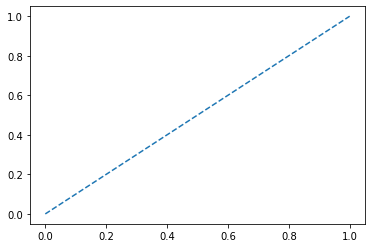

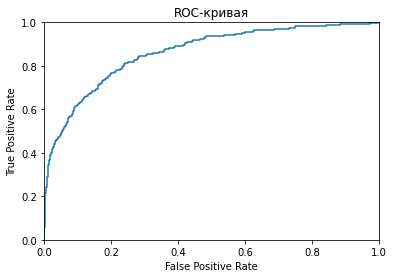

In [18]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]


fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [19]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test,probabilities_one_test) 
auc_roc

0.8612967571920065

Мы исследовали AUC-ROC метрику и получили результат 0.86 - значительно выше случайного предсказания в 0.5. 

Проверим напоследок все те же меры и показатели на модели-пустышке:

In [20]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_upsampled, target_upsampled)
round(f1_score(dummy_model.predict(features_test), target_test), 4)

0.3458

**Выводы:**

1) Проведена предобработка данных: названия, пропуски, дубликаты, категории в числа;

2) Отработана модель случайного леса без балансировки классов;

3) Сбалансированы классы c помощью upsampling, подобраны наилучшие гиперпараметры случайного леса;

4) На тестовой выборке достигнута f1-мера 0.61;

5) Исследована метриа AUC-ROC, которая продемонстрировала значительное превышения случайной классификации.

6) Глупая моделька справляется с задачей значительно хуже нашей

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*